# Attention-Based Bidirectional Long Short-Term Memory Networks for Relation Classification(https://www.aclweb.org/anthology/P16-2034)

In [2]:
from IPython.display import display, Image

## Model

In this section we propose Att-BLSTM model in detail. As shown in Figure 1, the model proposed in this paper contains five components:

1. **Input layer:** input sentence to this model;
2. **Embedding layer:** map each word into a low dimension vector;
3. **LSTM layer:** utilize BLSTM to get high level features from step (2);
4. **Attention layer:** produce a weight vector, and merge word-level features from each time step into a sentence-level feature vector, by multiplying the weight vector;
5. **Output layer:** the sentence-level feature vector is finally used for relation classification.


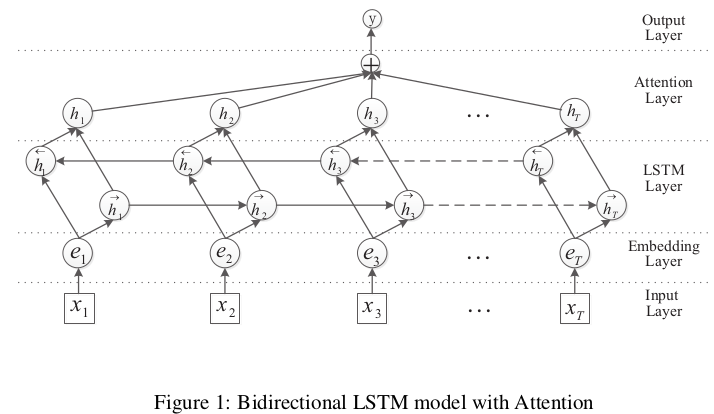

In [5]:
display(Image(filename='fig/BLSTMwithAtt.png'))

## Bidirectional Network

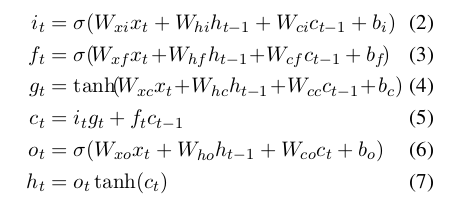

In [3]:
display(Image(filename='fig/BLSTM.png'))

## Attention

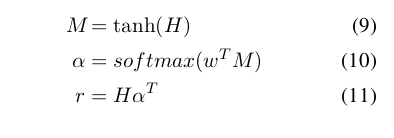

In [5]:
display(Image(filename='fig/Att.png'))

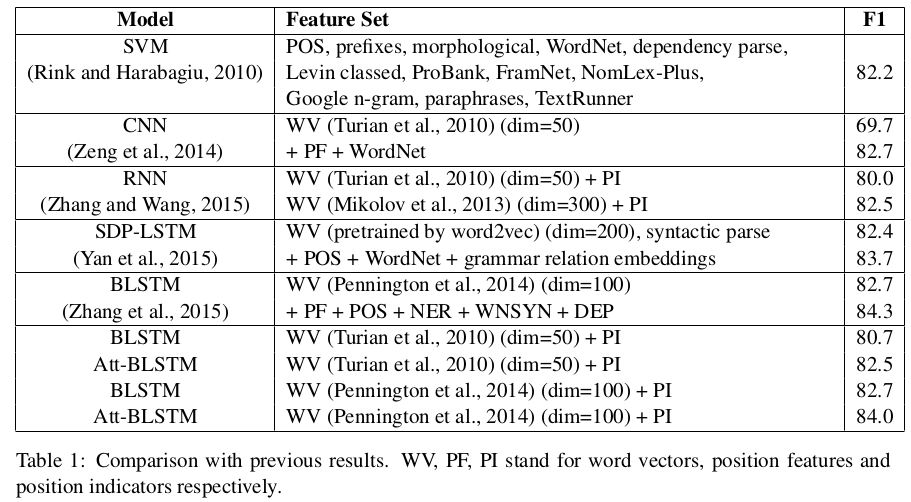

In [6]:
display(Image(filename='fig/ComparisonWithPreResult.png'))

## Classifying

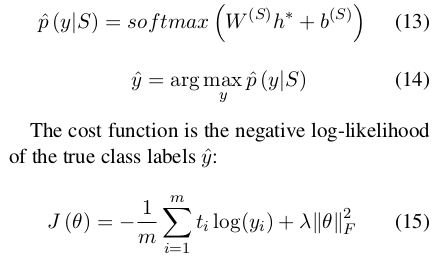

In [7]:
display(Image(filename='fig/Classifying.png'))

# Experiments

**Dataset**: Experiments are conducted on [DBpedia](https://wiki.dbpedia.org/develop/datasets)

## Dataset

The DBpedia datasets are licensed under the terms of the Creative Commons Attribution-ShareAlike License and the GNU Free Documentation License. For more information, please refer to http://dbpedia.org. For a recent overview paper about DBpedia, please refer to: Jens Lehmann, Robert Isele, Max Jakob, Anja Jentzsch, Dimitris Kontokostas, Pablo N. Mendes, Sebastian Hellmann, Mohamed Morsey, Patrick van Kleef, Sören Auer, Christian Bizer: DBpedia – A Large-scale, Multilingual Knowledge Base Extracted from Wikipedia. Semantic Web Journal, Vol. 6 No. 2, pp 167–195, 2015.

The DBPedia ontology classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu), licensed under the terms of the Creative Commons Attribution-ShareAlike License and the GNU Free Documentation License. This dataset was first used as a classification benchmark in the following technical report: Xiang Zhang, Yann LeCun, Text Understanding from Scratch, Arxiv 1502.01710.


DESCRIPTION

The DBpedia ontology classification dataset is constructed by picking 14 non-overlapping classes from DBpedia 2014. They are listed in classes.txt. From each of thse 14 ontology classes, we randomly choose 40,000 training samples and 5,000 testing samples. Therefore, the total size of the training dataset is 560,000 and testing dataset 70,000.

The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 3 columns in them, corresponding to class index (1 to 14), title and content. The title and content are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). There are no new lines in title or content.

In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from tensorflow.python.ops.rnn import bidirectional_dynamic_rnn as bi_rnn
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
from tensorflow.contrib.rnn import BasicLSTMCell
import time
from utils.model_helper import *

In [2]:
col=['class','title', 'content']

In [3]:
clas=["Company", "EducationalInstitution", "Artist","Athlete","OfficeHolder", "MeanOfTransportation", 
       "Building", "NaturalPlace", "Village", "Animal", "Plant", "Album", "Film", "WrittenWork"]

In [4]:
raw_train = pd.read_csv('dbpedia_data/dbpedia_csv/train.csv', names=col)

In [5]:
raw_test=pd.read_csv('dbpedia_data/dbpedia_csv/test.csv', names=col)

In [6]:
raw_train.head()

class                              title  \
0      1                   E. D. Abbott Ltd   
1      1                     Schwan-Stabilo   
2      1                         Q-workshop   
3      1  Marvell Software Solutions Israel   
4      1        Bergan Mercy Medical Center   

                                             content  
0   Abbott of Farnham E D Abbott Limited was a Br...  
1   Schwan-STABILO is a German maker of pens for ...  
2   Q-workshop is a Polish company located in Poz...  
3   Marvell Software Solutions Israel known as RA...  
4   Bergan Mercy Medical Center is a hospital loc...

In [7]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560000 entries, 0 to 559999
Data columns (total 3 columns):
class      560000 non-null int64
title      560000 non-null object
content    560000 non-null object
dtypes: int64(1), object(2)
memory usage: 12.8+ MB


In [26]:
raw_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 3 columns):
class      70000 non-null int64
title      70000 non-null object
content    70000 non-null object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [8]:
sample_ratio=2*1e-2

In [9]:
shuffle_train= raw_train.sample(frac=sample_ratio)
shuffle_test= raw_test.sample(frac=1e-1)

In [10]:
X_train=pd.Series(shuffle_train["content"])
y_train=pd.Series(shuffle_train["class"])
X_test=pd.Series(shuffle_test["content"])
y_test=pd.Series(shuffle_test["class"])

In [11]:
X_train.describe()

count                                                 11200
unique                                                11200
top        The Computer Underground Digest (CuD) was a w...
freq                                                      1
Name: content, dtype: object

In [12]:
y_train.describe()

count    11200.000000
mean         7.520625
std          3.999791
min          1.000000
25%          4.000000
50%          8.000000
75%         11.000000
max         14.000000
Name: class, dtype: float64

## Preprocessing

In [13]:
docs = ' '.join(X_train.to_list())

In [14]:

X_wc= WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(docs)

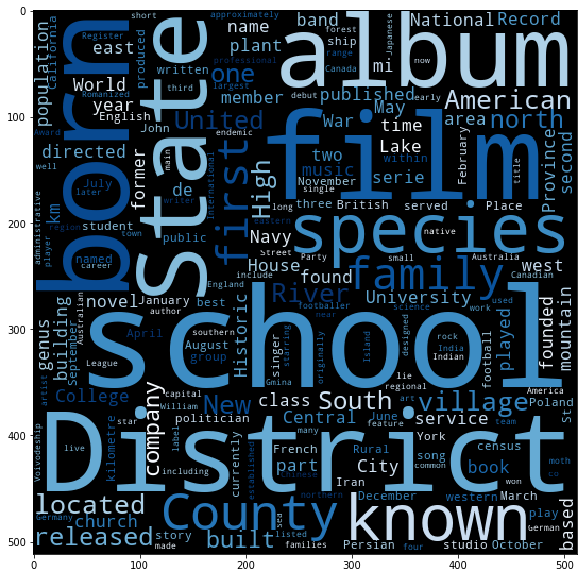

In [15]:
plt.figure(figsize = (10, 10))
plt.imshow(X_wc)
plt.show()

 Some popular words is class for example : film, album

In [16]:
def data_preprocessing_v2(train, test, max_len, max_words=50000):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(train)
    train_idx = tokenizer.texts_to_sequences(train)
    test_idx = tokenizer.texts_to_sequences(test)
    train_padded = pad_sequences(train_idx, maxlen=max_len, padding='post', truncating='post')
    test_padded = pad_sequences(test_idx, maxlen=max_len, padding='post', truncating='post')
    # vocab size = len(word_docs) + 2  (<UNK>, <PAD>)
    return train_padded, test_padded, max_words + 2

In [17]:
x_train, x_test, vocab_size =data_preprocessing_v2(X_train, X_test, max_len=32)
print("train size: ", len(x_train))
print("vocab size: ", vocab_size)

train size:  11200
vocab size:  50002


In [18]:
x_train.shape

(11200, 32)

In [19]:
def split_dataset(x_test, y_test, dev_ratio):
    """split test dataset to test and dev set with ratio """
    test_size = len(x_test)
    print(test_size)
    dev_size = (int)(test_size * dev_ratio)
    print(dev_size)
    x_dev = x_test[:dev_size]
    x_test = x_test[dev_size:]
    y_dev = y_test[:dev_size]
    y_test = y_test[dev_size:]
    return x_test, x_dev, y_test, y_dev, dev_size, test_size - dev_size

In [20]:
x_test, x_dev, y_test, y_dev, dev_size, test_size =split_dataset(x_test, y_test, 0.1)
print("Validation Size: ", dev_size)

7000
700
Validation Size:  700


## Model

In [21]:
class ABLSTM(object):
    def __init__(self, config):
        self.max_len = config["max_len"]
        self.hidden_size = config["hidden_size"]
        self.vocab_size = config["vocab_size"]
        self.embedding_size = config["embedding_size"]
        self.n_class = config["n_class"]
        self.learning_rate = config["learning_rate"]

        # placeholder
        self.x = tf.placeholder(tf.int32, [None, self.max_len])
        self.label = tf.placeholder(tf.int32, [None])
        self.keep_prob = tf.placeholder(tf.float32)

    def build_graph(self):
        print("building graph")
        # Word embedding
        embeddings_var = tf.Variable(tf.random_uniform([self.vocab_size, self.embedding_size], -1.0, 1.0),
                                     trainable=True)
        batch_embedded = tf.nn.embedding_lookup(embeddings_var, self.x)

        rnn_outputs, _ = bi_rnn(BasicLSTMCell(self.hidden_size),
                                BasicLSTMCell(self.hidden_size),
                                inputs=batch_embedded, dtype=tf.float32)

        fw_outputs, bw_outputs = rnn_outputs

        W = tf.Variable(tf.random_normal([self.hidden_size], stddev=0.1))
        H = fw_outputs + bw_outputs  # (batch_size, seq_len, HIDDEN_SIZE)
        M = tf.tanh(H)  # M = tanh(H)  (batch_size, seq_len, HIDDEN_SIZE)

        self.alpha = tf.nn.softmax(tf.reshape(tf.matmul(tf.reshape(M, [-1, self.hidden_size]),
                                                        tf.reshape(W, [-1, 1])),
                                              (-1, self.max_len)))  # batch_size x seq_len
        r = tf.matmul(tf.transpose(H, [0, 2, 1]),
                      tf.reshape(self.alpha, [-1, self.max_len, 1]))
        r = tf.squeeze(r)
        h_star = tf.tanh(r)  # (batch , HIDDEN_SIZE

        h_drop = tf.nn.dropout(h_star, self.keep_prob)

        # Fully connected layer（dense layer)
        FC_W = tf.Variable(tf.truncated_normal([self.hidden_size, self.n_class], stddev=0.1))
        FC_b = tf.Variable(tf.constant(0., shape=[self.n_class]))
        y_hat = tf.nn.xw_plus_b(h_drop, FC_W, FC_b)

        self.loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_hat, labels=self.label))

        # prediction
        self.prediction = tf.argmax(tf.nn.softmax(y_hat), 1)

        # optimization
        loss_to_minimize = self.loss
        tvars = tf.trainable_variables()
        gradients = tf.gradients(loss_to_minimize, tvars, aggregation_method=tf.AggregationMethod.EXPERIMENTAL_TREE)
        grads, global_norm = tf.clip_by_global_norm(gradients, 1.0)

        self.global_step = tf.Variable(0, name="global_step", trainable=False)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op = self.optimizer.apply_gradients(zip(grads, tvars), global_step=self.global_step,
                                                       name='train_step')
        print("graph built successfully!")



In [22]:
config = {
        "max_len": 32,
        "hidden_size": 64,
        "vocab_size": vocab_size,
        "embedding_size": 128,
        "n_class": 15,
        "learning_rate": 1e-3,
        "batch_size": 4,
        "train_epoch": 20
    }

In [23]:
def fill_feed_dict(data_X, data_Y, batch_size):
    """Generator to yield batches"""
    # Shuffle data first.
    shuffled_X, shuffled_Y = shuffle(data_X, data_Y)
    # print("before shuffle: ", data_Y[:10])
    # print(data_X.shape[0])
    # perm = np.random.permutation(data_X.shape[0])
    # data_X = data_X[perm]
    # shuffled_Y = data_Y[perm]
    # print("after shuffle: ", shuffled_Y[:10])
    for idx in range(data_X.shape[0] // batch_size):
        x_batch = shuffled_X[batch_size * idx: batch_size * (idx + 1)]
        y_batch = shuffled_Y[batch_size * idx: batch_size * (idx + 1)]
        yield x_batch, y_batch

In [99]:
from utils.prepare_data import *
import time
from utils.model_helper import *

In [24]:
classifier = ABLSTM(config)
classifier.build_graph()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
dev_batch = (x_dev, y_dev)
start = time.time()
for e in range(config["train_epoch"]):

    t0 = time.time()
    print("Epoch %d start !" % (e + 1))
    for x_batch, y_batch in fill_feed_dict(x_train, y_train, config["batch_size"]):
        return_dict = run_train_step(classifier, sess, (x_batch, y_batch))
        attn = get_attn_weight(classifier, sess, (x_batch, y_batch))
        # plot the attention weight
        # print(np.reshape(attn, (config["batch_size"], config["max_len"])))
    t1 = time.time()

    print("Train Epoch time:  %.3f s" % (t1 - t0))
    dev_acc = run_eval_step(classifier, sess, dev_batch)
    print("validation accuracy: %.3f " % dev_acc)

print("Training finished, time consumed : ", time.time() - start, " s")
print("Start evaluating:  \n")
cnt = 0
test_acc = 0
for x_batch, y_batch in fill_feed_dict(x_test, y_test, config["batch_size"]):
    acc = run_eval_step(classifier, sess, (x_batch, y_batch))
    test_acc += acc
    cnt += 1

print("Test accuracy : %f %%" % (test_acc / cnt * 100))

W0716 23:49:23.742660 139805360285504 deprecation.py:323] From <ipython-input-21-1d40046a139a>:22: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0716 23:49:23.744284 139805360285504 deprecation.py:323] From <ipython-input-21-1d40046a139a>:24: bidirectional_dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
W0716 23:49:23.745629 139805360285504 deprecation.py:323] From /home/hieudv/anaconda2/envs/aivin/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py:464: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN

building graph


W0716 23:49:24.358867 139805360285504 deprecation.py:506] From <ipython-input-21-1d40046a139a>:40: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0716 23:49:24.958670 139805360285504 deprecation.py:323] From /home/hieudv/anaconda2/envs/aivin/lib/python3.6/site-packages/tensorflow/python/ops/clip_ops.py:286: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


graph built successfully!
Epoch 1 start !
Train Epoch time:  226.672 s
validation accuracy: 0.924 
Epoch 2 start !
Train Epoch time:  257.041 s
validation accuracy: 0.954 
Epoch 3 start !
Train Epoch time:  246.307 s
validation accuracy: 0.951 
Epoch 4 start !
Train Epoch time:  250.423 s
validation accuracy: 0.961 
Epoch 5 start !
Train Epoch time:  225.818 s
validation accuracy: 0.963 
Epoch 6 start !
Train Epoch time:  194.967 s
validation accuracy: 0.950 
Epoch 7 start !
Train Epoch time:  199.150 s
validation accuracy: 0.947 
Epoch 8 start !
Train Epoch time:  204.007 s
validation accuracy: 0.957 
Epoch 9 start !
Train Epoch time:  192.416 s
validation accuracy: 0.959 
Epoch 10 start !
Train Epoch time:  185.529 s
validation accuracy: 0.957 
Epoch 11 start !
Train Epoch time:  231.487 s
validation accuracy: 0.964 
Epoch 12 start !
Train Epoch time:  226.854 s
validation accuracy: 0.956 
Epoch 13 start !
Train Epoch time:  234.674 s
validation accuracy: 0.961 
Epoch 14 start !
Trai

## Independently Recurrent Neural Network (IndRNN)[paper](https://arxiv.org/pdf/1803.04831.pdf)

In [ ]:
def linear(input_, output_size, scope=None):
    """
    Linear map: output[k] = sum_i(Matrix[k, i] * input_[i] ) + Bias[k]
    Args:
    input_: a tensor or a list of 2D, batch x n, Tensors.
    output_size: int, second dimension of W[i].
    scope: VariableScope for the created subgraph; defaults to "Linear".
  Returns:
    A 2D Tensor with shape [batch x output_size] equal to
    sum_i(input_[i] * W[i]), where W[i]s are newly created matrices.
  Raises:
    ValueError: if some of the arguments has unspecified or wrong shape.
  """

    shape = input_.get_shape().as_list()
    if len(shape) != 2:
        raise ValueError("Linear is expecting 2D arguments: %s" % str(shape))
    if not shape[1]:
        raise ValueError("Linear expects shape[1] of arguments: %s" % str(shape))
    input_size = shape[1]

    # Now the computation.
    with tf.variable_scope(scope or "SimpleLinear"):
        matrix = tf.get_variable("Matrix", [output_size, input_size], dtype=input_.dtype)
        bias_term = tf.get_variable("Bias", [output_size], dtype=input_.dtype)

    return tf.matmul(input_, tf.transpose(matrix)) + bias_term


def highway(input_, size, num_layers=1, bias=-2.0, f=tf.nn.relu, scope='Highway'):
    """Highway Network (cf. http://arxiv.org/abs/1505.00387).
    t = sigmoid(Wy + b)
    z = t * g(Wy + b) + (1 - t) * y
    where g is nonlinearity, t is transform gate, and (1 - t) is carry gate.
    """

    with tf.variable_scope(scope):
        for idx in range(num_layers):
            g = f(linear(input_, size, scope='highway_lin_%d' % idx))

            t = tf.sigmoid(linear(input_, size, scope='highway_gate_%d' % idx) + bias)

            output = t * g + (1. - t) * input_
            input_ = output

    return output

In [ ]:
class CNNClassfier(object):
    def __init__(self, config):
        # configuration
        self.max_len = config["max_len"]
        # topic nums + 1
        self.num_classes = config["n_class"]
        self.vocab_size = config["vocab_size"]
        self.embedding_size = config["embedding_size"]
        self.filter_sizes = config["filter_sizes"]
        self.num_filters = config["num_filters"]
        self.l2_reg_lambda = config["l2_reg_lambda"]
        self.learning_rate = config["learning_rate"]

        # placeholder
        self.x = tf.placeholder(tf.int32, [None, self.max_len], name="input_x")
        self.label = tf.placeholder(tf.int32, [None], name="input_y")
        self.keep_prob = tf.placeholder(tf.float32, name="keep_prob")

    def build_graph(self):
        print("building graph")
        l2_loss = tf.constant(0.0)
        with tf.variable_scope("discriminator"):
            # Embedding:
            with tf.device('/cpu:0'), tf.name_scope("embedding"):
                self.W = tf.Variable(
                    tf.random_uniform([self.vocab_size, self.embedding_size], -1.0, 1.0),
                    name="W")
                self.embedded_chars = tf.nn.embedding_lookup(self.W, self.x)  # batch_size * seq * embedding_size
                self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1) # expand dims for conv operation
            pooled_outputs = list()
            # Create a convolution + max-pool layer for each filter size
            for filter_size, filter_num in zip(self.filter_sizes, self.num_filters):
                with tf.name_scope("cov2d-maxpool%s" % filter_size):
                    filter_shape = [filter_size, self.embedding_size, 1, filter_num]
                    W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                    b = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="b")
                    conv = tf.nn.conv2d(
                        self.embedded_chars_expanded,
                        W,
                        strides=[1, 1, 1, 1],
                        padding="VALID",
                        name="conv")
                    # print(conv.name, ": ", conv.shape) batch * (seq - filter_shape) + 1 * 1(output channel) *
                    # filter_num
                    h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                    pooled = tf.nn.max_pool(
                        h,
                        ksize=[1, self.max_len - filter_size + 1, 1, 1],
                        strides=[1, 1, 1, 1],
                        padding='VALID',
                        name="pool")
                    # print(conv.name, ": ", conv.shape , "----", pooled.name, " : " ,pooled.shape)
                    pooled_outputs.append(pooled)
            total_filters_num = sum(self.num_filters)

            self.h_pool = tf.concat(pooled_outputs, 3)
            self.h_pool_flat = tf.reshape(self.h_pool, [-1, total_filters_num])  # batch * total_num

            # highway network
            with tf.name_scope("highway"):
                self.h_highway = highway(self.h_pool_flat, self.h_pool_flat.get_shape()[1], 1, 0)

            # add droppout
            with tf.name_scope("dropout"):
                self.h_drop = tf.nn.dropout(self.h_highway, self.keep_prob)

            with tf.name_scope("output"):
                W = tf.Variable(tf.truncated_normal([total_filters_num, self.num_classes], stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[self.num_classes]), name="b")
                l2_loss += tf.nn.l2_loss(W)
                l2_loss += tf.nn.l2_loss(b)
                self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
                self.ypred_for_auc = tf.nn.softmax(self.scores)
                self.prediction = tf.cast(tf.argmax(self.ypred_for_auc, 1), dtype=tf.int32)

            with tf.name_scope("loss"):
                losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.scores, labels=self.label)
                self.loss = losses + self.l2_reg_lambda * l2_loss
            with tf.name_scope("accuracy"):
                self.accuracy = tf.reduce_mean(
                    tf.cast(tf.equal(self.prediction, self.label), tf.float32))

        self.params = [param for param in tf.trainable_variables() if 'discriminator' in param.name]
        d_optimizer = tf.train.AdamOptimizer(self.learning_rate)
        # aggregation_method =2
        self.global_step = tf.Variable(0, name="global_step", trainable=False)
        grads_and_vars = d_optimizer.compute_gradients(self.loss, self.params, aggregation_method=2)
        self.train_op = d_optimizer.apply_gradients(grads_and_vars, global_step=self.global_step)
        print("graph built successfully!")


## Convolutional Neural Networks for Sentence Classification[paper](https://arxiv.org/abs/1408.5882)

In [ ]:
class CNNClassfier(object):
    def __init__(self, config):
        # configuration
        self.max_len = config["max_len"]
        # topic nums + 1
        self.num_classes = config["n_class"]
        self.vocab_size = config["vocab_size"]
        self.embedding_size = config["embedding_size"]
        self.filter_sizes = config["filter_sizes"]
        self.num_filters = config["num_filters"]
        self.l2_reg_lambda = config["l2_reg_lambda"]
        self.learning_rate = config["learning_rate"]

        # placeholder
        self.x = tf.placeholder(tf.int32, [None, self.max_len], name="input_x")
        self.label = tf.placeholder(tf.int32, [None], name="input_y")
        self.keep_prob = tf.placeholder(tf.float32, name="keep_prob")

    def build_graph(self):
        print("building graph")
        l2_loss = tf.constant(0.0)
        with tf.variable_scope("discriminator"):
            # Embedding:
            with tf.device('/cpu:0'), tf.name_scope("embedding"):
                self.W = tf.Variable(
                    tf.random_uniform([self.vocab_size, self.embedding_size], -1.0, 1.0),
                    name="W")
                self.embedded_chars = tf.nn.embedding_lookup(self.W, self.x)  # batch_size * seq * embedding_size
                self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1) # expand dims for conv operation
            pooled_outputs = list()
            # Create a convolution + max-pool layer for each filter size
            for filter_size, filter_num in zip(self.filter_sizes, self.num_filters):
                with tf.name_scope("cov2d-maxpool%s" % filter_size):
                    filter_shape = [filter_size, self.embedding_size, 1, filter_num]
                    W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                    b = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="b")
                    conv = tf.nn.conv2d(
                        self.embedded_chars_expanded,
                        W,
                        strides=[1, 1, 1, 1],
                        padding="VALID",
                        name="conv")
                    # print(conv.name, ": ", conv.shape) batch * (seq - filter_shape) + 1 * 1(output channel) *
                    # filter_num
                    h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                    pooled = tf.nn.max_pool(
                        h,
                        ksize=[1, self.max_len - filter_size + 1, 1, 1],
                        strides=[1, 1, 1, 1],
                        padding='VALID',
                        name="pool")
                    # print(conv.name, ": ", conv.shape , "----", pooled.name, " : " ,pooled.shape)
                    pooled_outputs.append(pooled)
            total_filters_num = sum(self.num_filters)

            self.h_pool = tf.concat(pooled_outputs, 3)
            self.h_pool_flat = tf.reshape(self.h_pool, [-1, total_filters_num])  # batch * total_num

            # highway network
            with tf.name_scope("highway"):
                self.h_highway = highway(self.h_pool_flat, self.h_pool_flat.get_shape()[1], 1, 0)

            # add droppout
            with tf.name_scope("dropout"):
                self.h_drop = tf.nn.dropout(self.h_highway, self.keep_prob)

            with tf.name_scope("output"):
                W = tf.Variable(tf.truncated_normal([total_filters_num, self.num_classes], stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[self.num_classes]), name="b")
                l2_loss += tf.nn.l2_loss(W)
                l2_loss += tf.nn.l2_loss(b)
                self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
                self.ypred_for_auc = tf.nn.softmax(self.scores)
                self.prediction = tf.cast(tf.argmax(self.ypred_for_auc, 1), dtype=tf.int32)

            with tf.name_scope("loss"):
                losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.scores, labels=self.label)
                self.loss = losses + self.l2_reg_lambda * l2_loss
            with tf.name_scope("accuracy"):
                self.accuracy = tf.reduce_mean(
                    tf.cast(tf.equal(self.prediction, self.label), tf.float32))

        self.params = [param for param in tf.trainable_variables() if 'discriminator' in param.name]
        d_optimizer = tf.train.AdamOptimizer(self.learning_rate)
        # aggregation_method =2
        self.global_step = tf.Variable(0, name="global_step", trainable=False)
        grads_and_vars = d_optimizer.compute_gradients(self.loss, self.params, aggregation_method=2)
        self.train_op = d_optimizer.apply_gradients(grads_and_vars, global_step=self.global_step)
        print("graph built successfully!")